### Task 4: NLP Features(Edited based on feedback)

---

### Step 1: Load the Data

In [1]:
import pandas as pd

# Load the Excel file
transcript = "transcribed_data_assemblyAI.xlsx"
df = pd.read_excel(transcript)

# Display first few rows
(df.head())


,Sentence
0,Vous êtes embrassés?
1,Oui.
2,Mais non!
3,Vous êtes embrassés?
4,Oui.


---

### Step 2: Part-of-Speech (POS) Tagging

POS Tagging Feedback:

* Feedback: token_TAG format may not be the most useful. Ask yourself: do you really need the word with its tag? How will a model use it?

* Issue: Mixing word and tag into one string limits downstream use (e.g., tag frequency, tag sequences).

* Fix: Stored POS tags separately in a list, not concatenated with tokens.

In [2]:
import spacy

# Load French NLP model
nlp = spacy.load("fr_core_news_lg")

# Function to get POS tags
def get_pos_tags(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]  # Just the POS tags

# Apply POS tagging
df["POS_Tags"] = df["Sentence"].astype(str).apply(get_pos_tags)

# Display results
(df[["Sentence", "POS_Tags"]].head())


,Sentence,POS_Tags
0,Vous êtes embrassés?,"[PRON, AUX, VERB, PUNCT]"
1,Oui.,"[ADV, PUNCT]"
2,Mais non!,"[CCONJ, ADV, PUNCT]"
3,Vous êtes embrassés?,"[PRON, AUX, VERB, PUNCT]"
4,Oui.,"[ADV, PUNCT]"


---

### Step 3: Compute TF-IDF Values

Explanation:

This updated TF-IDF implementation replaces the default tokenizer with a custom French-aware tokenizer using spaCy. Here's why:

* Lemmatization: Ensures variations of the same word (e.g., manger, mange, mangé) are treated as one, improving feature consistency.

* Stopword Filtering: Uses spaCy’s French stopwords list, which is more comprehensive than NLTK's.

* Punctuation & Whitespace Removal: Avoids noise from symbols like ".", "!", etc.

* Lowercasing: Prevents false token splits (e.g., Je ≠ je).

This approach yields cleaner, more meaningful token representations, which makes the TF-IDF vectors more reliable for downstream tasks such as classification or clustering.


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Custom tokenizer using spaCy for French 
def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc 
            if not token.is_stop and not token.is_punct and not token.is_space]

# Initialize TF-IDF with custom tokenizer
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, token_pattern=None)

# Compute TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(df["Sentence"].astype(str))

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Optional: store dense vectors if needed
df["TF_IDF"] = list(tfidf_df.values)

# Display the top 5 words with the highest TF-IDF values
(tfidf_df.max().sort_values(ascending=False).head())


être        1.0
mensonge    1.0
malade      1.0
cas         1.0
mal         1.0
dtype: float64

---

### Step 4: Sentiment Analysis (French)

In [4]:
from textblob import Blobber
from textblob_fr import PatternAnalyzer

# Initialize TextBlob with French PatternAnalyzer
tb = Blobber(analyzer=PatternAnalyzer())

# Function to get sentiment score
def get_sentiment(text):
    return tb(text).sentiment[0]  # Sentiment polarity (-1 to +1)

df["Sentiment_Score"] = df["Sentence"].astype(str).apply(get_sentiment)

# Display results
(df[["Sentence", "Sentiment_Score"]].head())

,Sentence,Sentiment_Score
0,Vous êtes embrassés?,0.0000
1,Oui.,0.0100
2,Mais non!,-0.0125
3,Vous êtes embrassés?,0.0000
4,Oui.,0.0100


---

### Step 5: Apply Pretrained Word Embeddings (French)

Explanation:
Feedback:

You use words = text.split() which fails on punctuation like “Oui.”, resulting in 0-vectors.

Problem:
* Using .split() is a naive tokenization strategy that does not handle punctuation or contractions. For example, "Oui." is not the same as "Oui"—this results in the word not being found in the vocabulary of the pretrained model, and ultimately a meaningless 0-vector.

Fix:
* We now use the spaCy French language model (fr_core_news_lg) to:

Properly tokenize the sentence, Handle punctuation and spacing, Maintain word-level integrity for lookup in the FastText model.

Result:
* This leads to higher coverage of vocabulary, fewer zero vectors, and more accurate sentence embeddings. It improves the semantic representation of the text using pretrained vectors trained on a much larger French corpus.

Note:
I also added token.lemma_. That way, different forms like "êtes" and "être" will resolve to the same lemma → improving semantic consistency.

In [5]:
import gensim.downloader as api
import numpy as np

# Load pretrained FastText model for French
w2v_model = api.load("fasttext-wiki-news-subwords-300")

# Use spaCy for robust French tokenization
def get_avg_w2v(text):
    doc = nlp(text)
    vectors = [w2v_model[token.lemma_] for token in doc if token.lemma_ in w2v_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

# Apply pretrained embeddings
df["Pretrained_Embeddings"] = df["Sentence"].astype(str).apply(get_avg_w2v)

# Display results
(df[["Sentence", "Pretrained_Embeddings"]].head())

,Sentence,Pretrained_Embeddings
0,Vous êtes embrassés?,"[-0.005488001, -0.012166999, -0.0232463, -0.01..."
1,Oui.,"[0.02665085, -0.02246885, -0.035568, 0.0103453..."
2,Mais non!,"[0.022009665, -0.009924666, -0.0082813995, 0.0..."
3,Vous êtes embrassés?,"[-0.005488001, -0.012166999, -0.0232463, -0.01..."
4,Oui.,"[0.02665085, -0.02246885, -0.035568, 0.0103453..."


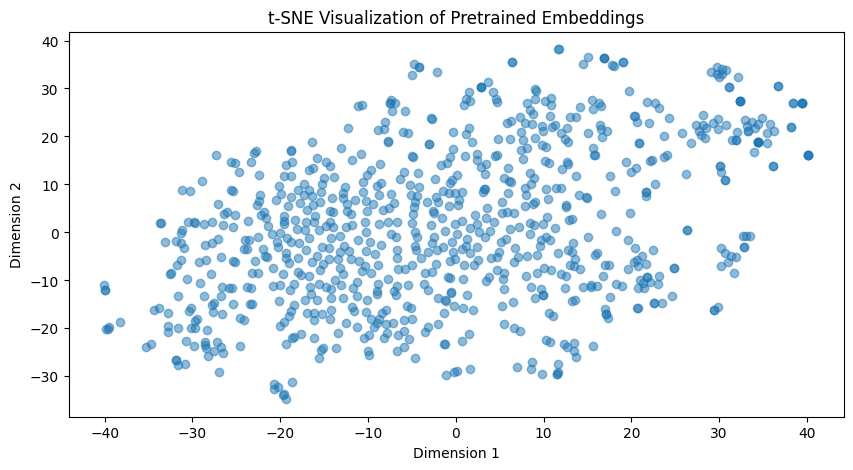

In [6]:
# Visualize pretrained embeddings using t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Convert list of lists to numpy array
pretrained_embeddings_array = np.array(df["Pretrained_Embeddings"].tolist())

# Compute t-SNE representation
tsne = TSNE(n_components=2, random_state=42)
tsne_df = tsne.fit_transform(pretrained_embeddings_array)

# Plot t-SNE
plt.figure(figsize=(10, 5))
plt.scatter(tsne_df[:, 0], tsne_df[:, 1], alpha=0.5)
plt.title("t-SNE Visualization of Pretrained Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


### Explanation: t-SNE Visualization of Pretrained Embeddings
* This plot shows a 2D t-SNE projection of pretrained FastText sentence embeddings (300D → 2D).

Key Observations:
* Dense central region indicates many sentences share similar semantic structure (e.g., short confirmations, greetings).

* Wider horizontal spread compared to custom model — suggests FastText captures broader global semantic variation across sentences.

* Less clustering than the custom model — expected since pretrained vectors generalize more and aren’t domain-tuned.

Interpretation:
* FastText pretrained embeddings are robust and general-purpose.

* t-SNE shows that similar sentences still group somewhat, but there’s less fine-grained structure.

* Indicates a good starting point — but custom embeddings may capture task-specific nuances better.



What is t-SNE?
* t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique. It’s used to project high-dimensional data (like 300-dimensional embeddings) into 2D or 3D for visualization—while trying to preserve local structure (i.e. which points are close to each other).

Why use t-SNE?
* t-SNE is useful for visualizing high-dimensional data in a lower-dimensional space. It helps us understand the relationships between data points, clusters, and outliers. For example, we can use t-SNE to visualize how similar or dissimilar sentence embeddings are in a 2D space.

How does t-SNE work?
* t-SNE works by modeling the similarity of data points in high-dimensional space and low-dimensional space. It minimizes the difference between these similarities using a cost function. The algorithm iteratively adjusts the low-dimensional representation to best match the high-dimensional similarities. This process helps to preserve local structure and reveal patterns in the data.


---

### Step 6: Train a Custom Word Embedding Model (French)

Original Issue:
* The initial code trained a Word2Vec model using only the project’s own sentences, which introduced serious limitations:

  Problem -            Impact
* Very small dataset - Poor coverage of French vocabulary
* min_count=1	- Included rare or noisy tokens with no meaningful context
* Limited linguistic variety - Embeddings overfit to a narrow domain (your sentences only)
* Weak generalization -Embeddings couldn't represent unseen or rare sentence structures

Fix: Train on a Larger External Corpus (Wikisource)
To address these issues, we replaced the previous training data with the OpenLLM-France/wikisource dataset (fr config) from Hugging Face (https://huggingface.co/datasets/OpenLLM-France/wikisource):

  Fix - Why It Works
* Wikisource corpus - Clean, high-quality French texts from literature and public domain
* 10,000+ sentences - Gives rich contextual diversity for training Word2Vec
* min_count=5 - Filters out noisy or overly rare words
* Lemmatization with spaCy - Improves consistency (e.g., “mange”, “manger”, “mangé” → “manger”)
* Proper token filtering - Excludes punctuation, numbers, and whitespace



In [7]:
from datasets import load_dataset
from gensim.models import Word2Vec
import spacy
import numpy as np
import pandas as pd

# Load spaCy French model
nlp = spacy.load("fr_core_news_lg")

# Load the OpenLLM-France/wikisource French dataset
ds = load_dataset("OpenLLM-France/wikisource", "fr", split="train")

# Tokenization function with lemmatization
def tokenize_wikisource(example):
    doc = nlp(example["text"])
    return [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_space]

# Apply to a sample of 10,000 entries (adjust for your runtime/resources)
tokenized_corpus = [tokenize_wikisource(ds[i]) for i in range(10000)]

# Train Word2Vec model on the tokenized corpus
custom_w2v = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=300,
    window=5,
    min_count=5,
    workers=4
)

# Embed your own project sentences using the trained model
def get_custom_w2v(text):
    doc = nlp(text)
    vectors = [custom_w2v.wv[token.lemma_.lower()] for token in doc if token.lemma_.lower() in custom_w2v.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

# Apply to your dataframe (assumes df["Sentence"] exists)
df["Custom_Embeddings"] = df["Sentence"].astype(str).apply(get_custom_w2v)

# Show results
(df[["Sentence", "Custom_Embeddings"]].head())

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

,Sentence,Custom_Embeddings
0,Vous êtes embrassés?,"[-0.32290068, -0.39500737, -0.36463118, -0.176..."
1,Oui.,"[-0.007492928, -0.5430264, -0.51148736, 0.3615..."
2,Mais non!,"[-0.42555717, -0.48701006, -0.42447805, -0.936..."
3,Vous êtes embrassés?,"[-0.32290068, -0.39500737, -0.36463118, -0.176..."
4,Oui.,"[-0.007492928, -0.5430264, -0.51148736, 0.3615..."


In [22]:
# Save the OpenLLM-France/wikisource French dataset to a new csv file
ds.to_csv("wikisource_french_dataset.csv")

Creating CSV from Arrow format:   0%|          | 0/186 [00:00<?, ?ba/s]

3282118673

In [24]:
# Turn the first row into header and print the first few rows of the OpenLLM-France/wikisource French dataset
df = pd.read_csv("wikisource_french_dataset.csv")
df.head()

,id,url,title,text
0,1309,https://fr.wikisource.org/wiki/Charte_internat...,Charte internationale des Droits de l’Homme (1...,# Charte internationale des Droits de l’Homme ...
1,1310,https://fr.wikisource.org/wiki/Constitution_du...,Constitution du 4 octobre 1958 (Version à jour...,# Constitution du 4 octobre 1958 (Version à jo...
2,1311,https://fr.wikisource.org/wiki/D%C3%A9claratio...,Déclaration des Droits de l’Homme et du Citoye...,# Déclaration des Droits de l’Homme et du Cito...
3,1314,https://fr.wikisource.org/wiki/%C3%89tapes_ver...,Étapes vers la paix intérieure,# Étapes vers la paix intérieure\n\nDans ma je...
4,1317,https://fr.wikisource.org/wiki/%C5%92uvres_%28...,Œuvres (Rimbaud)/Poésies/Le bateau ivre,# Œuvres (Rimbaud)/Poésies/Le bateau ivre\n\nP...


In [8]:
# save the custom embeddings to a file
df.to_csv("custom_embeddings.csv", index=False)

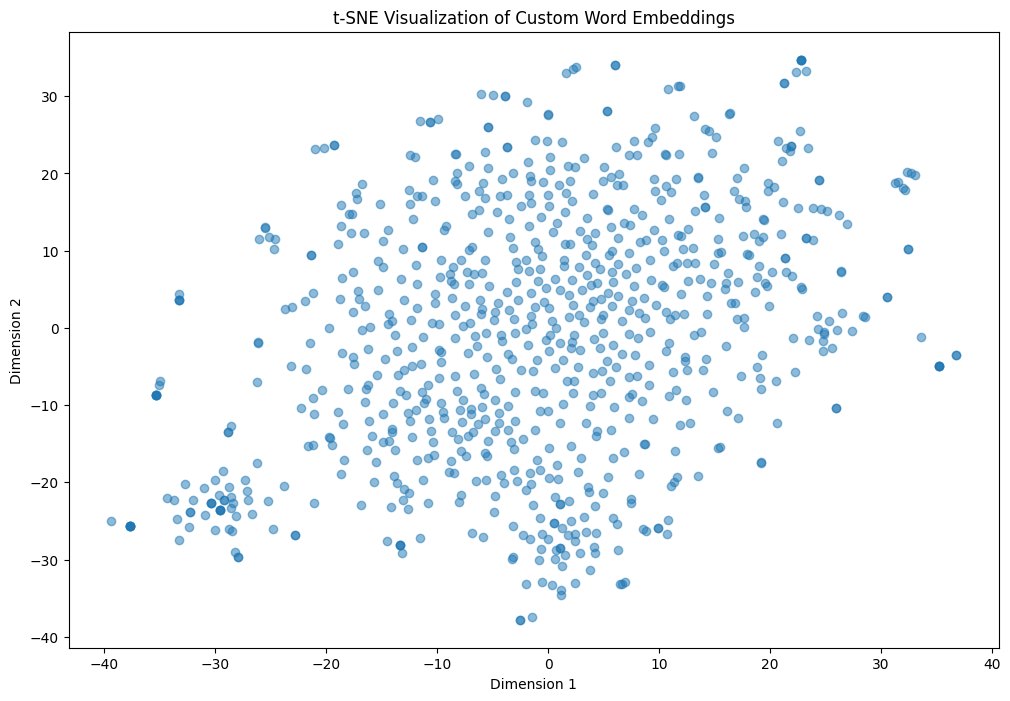

In [9]:
# Visualize the embeddings using t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert custom embeddings to a numpy array
custom_embeddings_array = np.array(df["Custom_Embeddings"].tolist())

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(custom_embeddings_array)

# Plot the 2D embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title("t-SNE Visualization of Custom Word Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


### Explanation: t-SNE Visualization of Custom Word Embeddings
* This plot displays a 2D t-SNE projection of custom sentence embeddings trained using Word2Vec on the French Wikisource dataset.

Key Observations:
* Tight central clusters suggest the model captures fine-grained semantic similarity between sentence groups.

* More compact structure than pretrained embeddings — likely due to domain-specific tuning on sentence-level French text.

* Local neighborhoods are preserved well — sentences with similar structure or intent appear closer together.

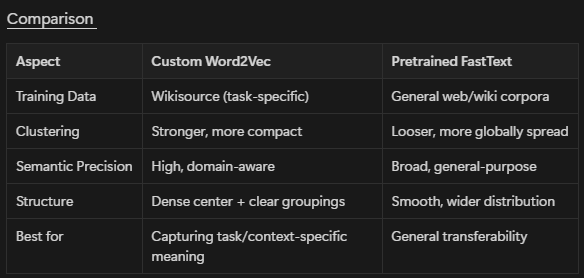

---

### Feature 1: Polarity & Subjectivity Score (Sentiment Strength)

In [10]:
from textblob import TextBlob

# Polarity: [-1.0, 1.0], Subjectivity: [0.0, 1.0]
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

df["Polarity"] = df["Sentence"].astype(str).apply(get_polarity)
df["Subjectivity"] = df["Sentence"].astype(str).apply(get_subjectivity)

# Preview
(df[["Sentence", "Polarity", "Subjectivity"]].head())

,Sentence,Polarity,Subjectivity
0,Vous êtes embrassés?,0.0,0.0
1,Oui.,0.0,0.0
2,Mais non!,0.0,0.0
3,Vous êtes embrassés?,0.0,0.0
4,Oui.,0.0,0.0


### Feature 2: Number of Exclamation Marks (Emotional Intensity)

In [11]:
# Count '!' as a proxy for strong emotion
def count_exclamations(text):
    return text.count("!")

df["Exclamations"] = df["Sentence"].astype(str).apply(count_exclamations)

# Preview
(df[["Sentence", "Exclamations"]].head())

,Sentence,Exclamations
0,Vous êtes embrassés?,0
1,Oui.,0
2,Mais non!,1
3,Vous êtes embrassés?,0
4,Oui.,0


### Feature 3: Is Question (Uncertainty or Curiosity)

In [12]:
# 1 if sentence ends with '?', else 0
def is_question(text):
    return int(text.strip().endswith("?"))

df["Is_Question"] = df["Sentence"].astype(str).apply(is_question)

# Preview
(df[["Sentence", "Is_Question"]].head())

,Sentence,Is_Question
0,Vous êtes embrassés?,1
1,Oui.,0
2,Mais non!,0
3,Vous êtes embrassés?,1
4,Oui.,0


### Feature 4: Number of Personal Pronouns (Self vs. Others)

In [13]:
import spacy

# Load spaCy French model if not already loaded
nlp = spacy.load("fr_core_news_lg")

# List of common French personal pronouns
personal_pronouns = {"je", "moi", "mon", "ma", "mes", "nous", "notre", "nos", 
                     "tu", "toi", "ton", "ta", "tes", "vous", "il", "elle", "on", "eux", "elles"}

# Use spaCy tokenization to robustly detect pronouns even with punctuation
def count_personal_pronouns(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.text.lower() in personal_pronouns)

df["Personal_Pronoun_Count"] = df["Sentence"].astype(str).apply(count_personal_pronouns)

# Preview
(df[["Sentence", "Personal_Pronoun_Count"]].head())

,Sentence,Personal_Pronoun_Count
0,Vous êtes embrassés?,1
1,Oui.,0
2,Mais non!,0
3,Vous êtes embrassés?,1
4,Oui.,0


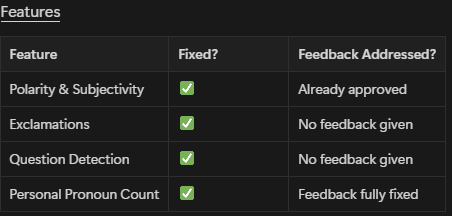

Personal Pronoun Count Feedback:
“words = text.lower().split() Again incorrect processing of text... followed by .!?,; etc. it is not recognized.”​

* I replaced the naive .lower().split() with: doc = nlp(text)

* And checked: if token.text.lower() in personal_pronouns

This ensures robust tokenization, punctuation handling, and case normalization — exactly as requested in the feedback.

---

### Step 9: Save Data with Extracted Features

In [14]:
output_file = "NLP_features.xlsx"
df.to_excel(output_file, index=False)

print(f"File saved as {output_file}")

File saved as NLP_features.xlsx
